# 模型融合预测与交易决策引擎

---

### **目标**
本 Notebook 是整个项目的**应用终端**。它的核心职责是模拟实盘环境，对指定的股票执行完整的“数据-预测-决策”流程。

### **工作流程**
1.  **环境设置与目标选定**: 导入库，加载配置，并指定今天要进行预测的目标股票。
2.  **加载已训练构件**: 
    - 自动查找并加载目标股票**最新版本**的 LGBM 和 LSTM 模型。
    - 加载对应的 `StandardScaler`。
    - 加载两个模型完整的 IC 历史记录，用于动态权重计算。
3.  **获取最新特征**: 调用数据处理流水线，获取截至**今天**的最新一行特征数据。
4.  **独立模型预测**: 分别使用 LGBM 和 LSTM 模型对最新特征进行预测。
5.  **动态权重融合**: 
    - 基于 IC 历史计算出 LGBM 和 LSTM 当前的动态权重。
    - 对两个模型的预测值（经过 Z-score 标准化）进行加权融合，得到最终的预测信号。
6.  **风险审批与决策输出**: 
    - 将融合后的信号提交给 `RiskManager` 进行最终审批（如重复信号检查）。
    - 根据审批结果，输出明确的交易决策（如：**【批准开仓：买入】** 或 **【信号被拒：重复信号】**）。

## 1. 环境设置与目标选定

d:\Project\Command\Python\Neural\Wolf_of_Wall_Street\main_train.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


--- INFO: 预测引擎 (Prophet) 已初始化。 ---
--- 正在初始化环境：加载配置与模块... ---
INFO: 底层并行计算库线程数已设置为: 4
INFO: 项目模块导入成功。
SUCCESS: 配置已从 'configs/config.yaml' 加载。
=== 主工作流：启动单点预测 ===

--- 步骤1：加载所有已训练构件 (自动查找最新版本) ---
  - 正在加载 LGBM 的构件...
    - SUCCESS: LGBM 版本 '20250930' 已加载。
  - 正在加载 LSTM 的构件...
    - SUCCESS: LSTM 版本 '20250930' 已加载。
  - 正在加载 TABTRANSFORMER 的构件...
    - SUCCESS: TabTransformer 版本 '20250930' 已加载。
  - INFO: 正在加载训练时使用的特征列表...
    - SUCCESS: 已从 LGBM 的元数据加载特征列表 (84个)。
  - [DIAGNOSTIC] ModelFuser initialized. Version: 20250930. Fuser path set to: D:\Project\Command\Python\Neural\Wolf_of_Wall_Street\data\models\000100.SZ\fuser_model_20250930.pkl
  - [MEMORY_ID] New ModelFuser instance created. ID: 2622700757280
  - [DIAGNOSTIC] Fuser.load() called. Checking for path: D:\Project\Command\Python\Neural\Wolf_of_Wall_Street\data\models\000100.SZ\fuser_model_20250930.pkl
  - [DIAGNOSTIC] File exists? True. Scaler exists? True
SUCCESS: 融合构件 (版本 20250930)已成功加载。
INFO: 确保运行时数据目录 'data\runtime_data' 已存在。
S

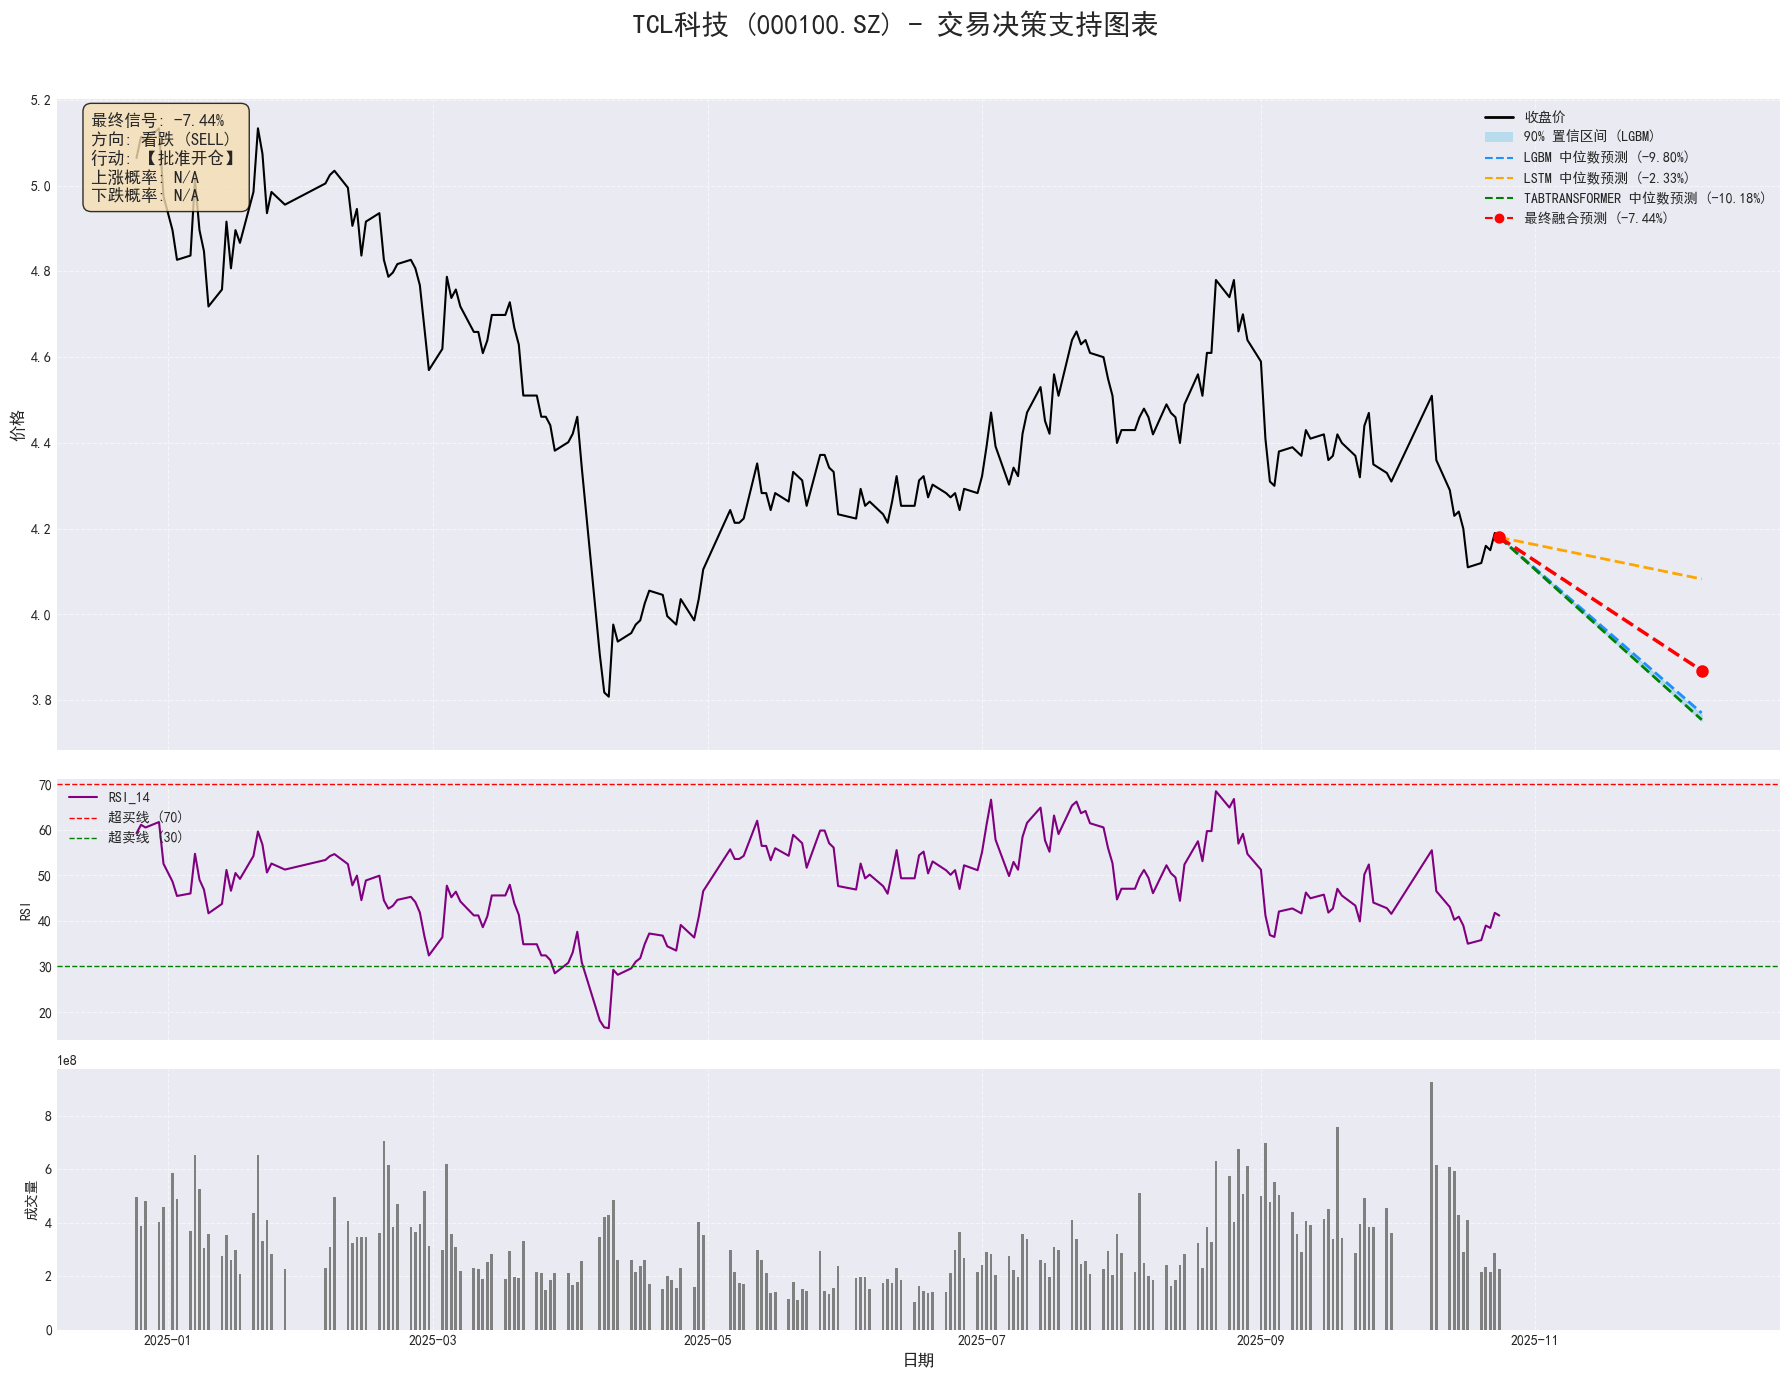


=== 单点预测工作流已成功为 TCL科技 (000100.SZ) 执行完毕！ ===


In [1]:
# 文件路径: Prophet.ipynb

import sys
from pathlib import Path

# --- 1. 动态导入 main_train 核心引擎 ---
project_root = str(Path().resolve())
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from main_train import run_load_config_and_modules, run_single_stock_prediction
    print("--- INFO: 预测引擎 (Prophet) 已初始化。 ---")
except ImportError as e:
    raise ImportError(f"FATAL: 无法从 main_train.py 导入核心函数: {e}")

# --- 2. 加载全局配置和模块 ---
# 在 Notebook 的生命周期中，我们只加载一次
config, modules = run_load_config_and_modules()

if not (config and modules):
    raise RuntimeError("环境初始化失败，请检查配置文件路径和模块导入。")

# --- 3. (可选) 在此手动指定要预测的股票 ---
# 如果留空，则会使用 config.yaml 中 application_settings.prophet_target_ticker 定义的值
TARGET_TICKER_OVERRIDE = '000100.SZ' # 例如: '000100.SZ'

# --- 4. 执行单点预测工作流 ---
if config and modules:
    try:
        run_single_stock_prediction(
            config=config, 
            modules=modules, 
            target_ticker=TARGET_TICKER_OVERRIDE
        )
    except Exception as e:
        print(f"\n--- ERROR: 在执行单点预测时发生严重错误 ---")
        print(e)
        import traceback
        traceback.print_exc()